## PINNsを理解するための一次元単振動のデモンストレーション
このノートブックでは、PINNを最も単純に理解するためにタイトルの通り単振動のモデリングを行います。  
PINNsでは、ニューラルネットワークを関数近似器として微分方程式の近似解を学習するようなイメージで学習を行います。（個人的には、この部分が普通のいわゆるAIと頭の使い方が異なる部分であり、面白さだと思っています。）もちろん、やっていることは回帰タスクなのですが、この近似器の雰囲気も感じていただけると嬉しいです。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


### データセットの準備
今回は単振動を取り扱うので、扱う変数は、時間(t)と変位(y)の二つになります。
numpyのlinspaceを用いて、tを[0,10]から1,000点均等にサンプルし、それに対応するyの値をy=sin(t)で求めます。(後で出てきますが、今回利用する単振動の解になっています。)　物理予測をする場合、解はもとまっていない（当然ですよね。回わかっているなら機械学習で求める必要ない）ので、この部分は実際のデータを入れることになります。
最終的に、コレらのデータはtorchのテンソル型に変換されています。

In [2]:
# データセットのパラメータ
num_samples = 1000
t = np.linspace(0, 10, num_samples)
y = np.sin(t)

# データをTensorに変換
t_tensor = torch.tensor(t, dtype=torch.float32, requires_grad=True).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=True).view(-1, 1)


### モデルの定義
ここでやっとモデルを定義できます。ただ、冒頭でも言ったように一般的な機械学習のモデルというよりも、本当に原始的な関数（しかしブラックボックスで値を入力するとなぜか近い値を返すボックス）のようなイメージの方が良いかもしれません。入力が1で出力1の二層ニューラルネットを作成しました。

In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.fc(x)


### Physics Informed Lossの定義
ここで、PINNsの語源となっているPhysics-Informed Lossを定義します。
単振動の支配方程式が次のようになっているとする。  　$\frac{d^2y}{dt^2} +y = 0$  
この物理ロスとして、左辺と右辺の残差を利用するが、これは要するに左辺の値の絶対値か2乗を取れば良いことになる。


In [4]:
def physics_informed_loss(model_output, t):
    y = model_output
    # 1階微分
    dy_dt = torch.autograd.grad(y.sum(), t, create_graph=True)[0]
    # 2階微分
    d2y_dt2 = torch.autograd.grad(dy_dt.sum(), t, create_graph=True)[0]
    
    # 単振動の方程式
    
    loss = (d2y_dt2 + y).pow(2).mean()
    return loss


### モデルの学習
モデルの形状は、先ほど指定したSimpleModelを利用し、criterion（損失）にまずは二乗誤差を格納する。optimizerとしてはAdamを適用。  
次に、epochsの数を指定し、何回学習を回すか指定する。  
そして各epochの中でphysics-informed lossとmse lossを足したものを新たに損失として定義し、このlossの勾配降下を行う。
loss.backwardを使って、lossの勾配を計算し、optimizer.stepによって、パラメータの更新が行われる。

In [5]:
# 訓練ループ
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(t_tensor)
    mse_loss = criterion(y_pred, y_tensor)
    phys_loss = physics_informed_loss(y_pred, t_tensor)
    
    # 合成損失
    loss = mse_loss + phys_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {mse_loss.item():.4f}, Physics Loss: {phys_loss.item():.4f}')



Epoch [100/100000], MSE Loss: 0.0902, Physics Loss: 0.0451
Epoch [200/100000], MSE Loss: 0.0008, Physics Loss: 0.0009
Epoch [300/100000], MSE Loss: 0.0001, Physics Loss: 0.0002
Epoch [400/100000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [500/100000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [600/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [700/100000], MSE Loss: 0.0003, Physics Loss: 0.0002
Epoch [800/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [900/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [1000/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [1100/100000], MSE Loss: 0.0009, Physics Loss: 0.0004
Epoch [1200/100000], MSE Loss: 0.0003, Physics Loss: 0.0003
Epoch [1300/100000], MSE Loss: 0.0002, Physics Loss: 0.0001
Epoch [1400/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [1500/100000], MSE Loss: 0.0000, Physics Loss: 0.0000
Epoch [1600/100000], MSE Loss: 0.0001, Physics Loss: 0.0001
Epoch [1700/100000], MSE Loss: 0.0000, Physics Lo

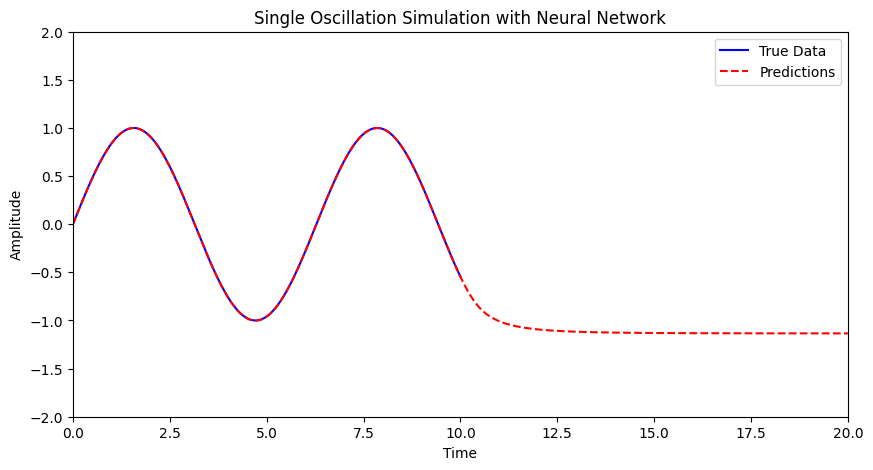

In [6]:
plt.figure(figsize=(10, 5))

x = np.linspace(0,20,2*num_samples)
x_tensor=torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1)
plt.plot(t, y, label='True Data', color='blue')
plt.plot(x, model(x_tensor).detach().numpy(), label='Predictions', color='red', linestyle='--')
plt.xlim(0,20)
plt.ylim(-2,2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Single Oscillation Simulation with Neural Network')
plt.show()


## おまけ
ここまでくると、physics informed lossだけだとどの程度の予測が可能か気になります。なので、0-20の区間で、教師なし学習（物理損失項のみ）でどの程度予測が可能か調べてみました。

In [13]:
# 訓練ループ
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    #mse_loss = criterion(y_pred, y_tensor)
    phys_loss = physics_informed_loss(y_pred, x_tensor)*10000
    
    # 合成損失
    loss = phys_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {mse_loss.item():.4f}, Physics Loss: {phys_loss.item():.4f}')



Epoch [100/10000], MSE Loss: 0.0000, Physics Loss: 0.0131
Epoch [200/10000], MSE Loss: 0.0000, Physics Loss: 0.0018
Epoch [300/10000], MSE Loss: 0.0000, Physics Loss: 0.0011
Epoch [400/10000], MSE Loss: 0.0000, Physics Loss: 0.0008
Epoch [500/10000], MSE Loss: 0.0000, Physics Loss: 0.0007
Epoch [600/10000], MSE Loss: 0.0000, Physics Loss: 0.0005
Epoch [700/10000], MSE Loss: 0.0000, Physics Loss: 0.0004
Epoch [800/10000], MSE Loss: 0.0000, Physics Loss: 0.0003
Epoch [900/10000], MSE Loss: 0.0000, Physics Loss: 0.0003
Epoch [1000/10000], MSE Loss: 0.0000, Physics Loss: 0.0002
Epoch [1100/10000], MSE Loss: 0.0000, Physics Loss: 0.0002
Epoch [1200/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [1300/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [1400/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [1500/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [1600/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch [1700/10000], MSE Loss: 0.0000, Physics Loss: 0.0001
Epoch 

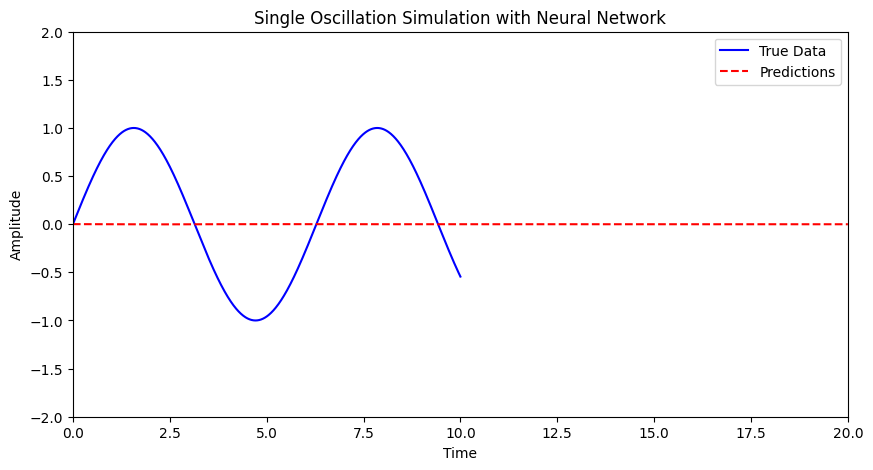

In [14]:
plt.figure(figsize=(10, 5))

x = np.linspace(0,20,2*num_samples)
x_tensor=torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1)
plt.plot(t, y, label='True Data', color='blue')
plt.plot(x, model(x_tensor).detach().numpy(), label='Predictions', color='red', linestyle='--')
plt.xlim(0,20)
plt.ylim(-2,2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Single Oscillation Simulation with Neural Network')
plt.show()